<a href="https://colab.research.google.com/github/akanksha-ahuja/fcc-final-notebooks/blob/main/fccml_experiment_1_x_graph_metrics_for_100_events_and_node_metrics_for_event_id_9_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libs

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import timeit
import random
import torch.nn.functional as F
import itertools
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')
import networkx as nx

In [2]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx

     |████████████████████████████████| 8.0 MB 4.1 MB/s 
     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 222 kB 4.1 MB/s 
     |████████████████████████████████| 376 kB 54.2 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Create Graph Datasets

In [4]:
# Data Processing Functions
def load_df(path_to_file):
  df = pd.read_csv(path_to_file)
  return df

def set_constants(TOTAL_EVENTS, MAX_LENGTH_EVENT=150):
  TOTAL_EVENTS = TOTAL_EVENTS
  MAX_LENGTH_EVENT = MAX_LENGTH_EVENT
  return TOTAL_EVENTS, MAX_LENGTH_EVENT

def create_labels(df):
  conditions = [(df['isHiggs'] == True),(df['isZ'] == True), (df['isOther'] == True) ]
  # create a list of the values we want to assign for each condition
  values = [0, 1, 2] 

  # create a new column and use np.select to assign values to it using our lists as arguments
  df['label'] = np.select(conditions, values)
  return df


def normalise_x_features(df):
  # Normalise the features in the dataset 
  df_id = df[['event_list']]
  df_x = df[['pid', 'pos_r', 'pos_theta', 'pos_phi', 'pos_t', 'mom_p', 'mom_theta', 'mom_phi', 'mom_mass']]
  df_y = df[['label']]

  # Create a list of labels for the new dataframe
  new_columns = ['event_list', 'pid', 'pos_r', 'pos_theta', 'pos_phi', 'pos_t', 'mom_p', 'mom_theta', 'mom_phi', 'mom_mass', 'label']

  x = df_x.values # returns numpy 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df_x = pd.DataFrame(x_scaled)

  # Concatenate normalised x features and un-normalised y labels and event ids
  df_normalised_features = pd.concat([df_id, df_x, df_y], axis=1)
  df_normalised_features.columns = new_columns # You need to mention the axis
  return df_normalised_features

def split_df_by_event(df_normalised_features, TOTAL_EVENTS):
  # Dataframes split by event 
  df_event_list = []
  for i in range(TOTAL_EVENTS):
    df_event = df_normalised_features[df_normalised_features['event_list']==i]
    df_event_list.append(df_event)

  # A list of number of stable particles per event 
  length_of_each_event = [len(df_event_list[i]) for i in range(len(df_event_list))]
  return df_event_list, length_of_each_event

def create_source_target_for_COO(df_event_list):
  # Add two columns of source, target over all dataframes in df_event_list to make it compatible with pygn Data Object.
  df_event_source_target_list = []
  for i in range(len(df_event_list)):
    df_event_list[i]['source'] = None
    df_event_list[i]['target'] = None
    df_event_source_target_list.append(df_event_list[i])
  return df_event_source_target_list

In [5]:
def get_event_ids_to_be_removed(path_to_file, TOTAL_EVENTS):
  df = load_df(path_to_file)
  df = create_labels(df)
  df = normalise_x_features(df)
  df_event_list_complete = []
  for i in range(TOTAL_EVENTS):
      df_event = df[df['event_list']==i]
      df_event_list_complete.append(df_event)

  n_others_list = []
  for event in df_event_list_complete:
    labels = event['label'].to_list()
    for node_id in range(len(event)):
      if labels[node_id] == 2:
        n_others_list.append(event['event_list'].values)

  event_ids_others = np.asarray(n_others_list)
  event_ids_others_unique = []
  for event_ids in event_ids_others:
    event_ids_others_unique.append(np.unique(event_ids))

  event_ids_to_be_removed = np.unique(np.asarray(event_ids_others_unique))
  return df, event_ids_to_be_removed


def get_updated_TOTAL_EVENTS(event_ids_to_be_removed, TOTAL_EVENTS):
  NO_OF_EVENTS_REMOVED = len(event_ids_to_be_removed)
  TOTAL_EVENTS -= NO_OF_EVENTS_REMOVED
  return TOTAL_EVENTS

def drop_all_rows_with_event_ids(df, event_ids_to_be_removed):
  for event_id in event_ids_to_be_removed:
    # print(event_id)
    df.drop(df[df['event_list']== event_id].index, inplace=True)
  # Save the file for manual fix 
  df['event_list'].to_csv('fix_column.csv')
  return "Saved"

# The fixed column is a file for 10,000 events, and you are processing all those events 
# If you want to process lesser events, update this method to choose a specific number of event ids
def get_df_with_fixed_event_id_column(df, path_to_file):
  df_new_column = pd.read_csv("/content/fixed_column.csv")
  new_column = df_new_column['Unnamed: 2'].values
  # Drop ['event_list] 
  df = df.drop("event_list", axis=1)
  # df = df.drop("Unnamed: 0", axis=1)
  # Replace the existing column with a new column 
  df['event_list'] = new_column
  column_names = ["event_list","pid",	"pos_r",	"pos_theta",	"pos_phi",	"pos_t",	"mom_p",	"mom_theta",	"mom_phi"	,"mom_mass"	,"label"]
  df = df.reindex(columns=column_names)
  return df

def create_df_with_only_H_Z_events(path_to_file="/content/output_11_07_2021.csv", path_to_file_fixed_columns='/content/fixed_column.csv', TOTAL_EVENTS=10000):
  df, event_ids_to_be_removed = get_event_ids_to_be_removed(path_to_file, TOTAL_EVENTS)
  TOTAL_EVENTS = get_updated_TOTAL_EVENTS(event_ids_to_be_removed, TOTAL_EVENTS)
  drop_all_rows_with_event_ids(df, event_ids_to_be_removed)
  df = get_df_with_fixed_event_id_column(df, path_to_file_fixed_columns)
  return df, TOTAL_EVENTS 
  

# Fixed Graph Sizes need further processing 
def process_df_create_fixed_size_events(df_single_event, MAX_LENGTH_EVENT, append_with_digits= 9999.0, category_assigned=3, label_column=-3):
  df_processed = df_single_event
  df_processed = df_processed.drop('event_list', axis=1)

  # Append the rows
  n_rows_to_append = MAX_LENGTH_EVENT - len(df_processed)
  # Creating the appending df 
  np_append = np.ones((n_rows_to_append, len(df_processed.columns)))
  # print(np_append)
  np_append = np_append * append_with_digits
  for x in range(n_rows_to_append):
    np_append[x][label_column] = category_assigned # Label Column
    np_append[x][-2] = None # Source Column 
    np_append[x][-1] = None # Target Column 

  # print(np_append)
  df_append = pd.DataFrame(data=np_append, columns=df_processed.columns)
  # Concat the two dfs
  df_fixed_size_event = pd.concat([df_processed, df_append])
  # Reset the index 
  df_fixed_size_event.reset_index(drop=True) # Drop the old index colum
  return df_fixed_size_event

def process_all_events(df_event_list, TOTAL_EVENTS, MAX_LENGTH_EVENT):
  df_event_processed_list = []
  for i in range(TOTAL_EVENTS):
    df_processed = process_df_create_fixed_size_events(df_event_list[i], MAX_LENGTH_EVENT)
    df_event_processed_list.append(df_processed)
  return df_event_processed_list

def clean_columns(df_event_processed_list, TOTAL_EVENTS):
  for event_id in range(TOTAL_EVENTS):
    df_event_processed_list[event_id]['source'] = None
    df_event_processed_list[event_id]['target'] = None
  return df_event_processed_list

def generate_graph_data_x_y_for_already_normalised_features(df_event_processed_list_cleaned, TOTAL_EVENTS):
  # Generating data.x and data.y for pytorch geomteric 
  graph_data_x_list = []
  graph_data_y_list = []
  for i in range(TOTAL_EVENTS):
    df_graph = df_event_processed_list_cleaned[i]
    # Extract node features and labels from cleaned processed fixed size event list and convert to numpy 
    data_x = df_graph[['pid', 'pos_r', 'pos_theta', 'pos_phi', 'pos_t', 'mom_p', 'mom_theta', 'mom_phi', 'mom_mass']].to_numpy()
    data_y = df_graph[['label']].to_numpy()

    # Convert numpy objects into tensors for data loaders 
    graph_data_x_list.append(torch.Tensor(data_x))
    graph_data_y_list.append(torch.Tensor(data_y))
  return graph_data_x_list, graph_data_y_list

# NORMALISES THE APPENDED PADDED NUMBERS - for FIXED SIZE GRAPHS 
def generate_graph_data_x_y(df_event_processed_list_cleaned, TOTAL_EVENTS):
  # Generating data.x and data.y for pytorch geomteric 
  graph_data_x_list = []
  graph_data_y_list = []
  for i in range(TOTAL_EVENTS):
    df_graph = df_event_processed_list_cleaned[i]
    df_x = df_graph[['pid', 'pos_r', 'pos_theta', 'pos_phi', 'pos_t', 'mom_p', 'mom_theta', 'mom_phi', 'mom_mass']]
    df_y = df_graph[['label']]

    # Normalise the features in the dataset 
    x = df_x.values # returns numpy 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_x = pd.DataFrame(x_scaled)

    # Convert the pandas dataframe to numpy 
    x_data = df_x.to_numpy()
    y_data = df_y.to_numpy()

    # Convert numpy objects into tensors for data loaders 
    x_data_tensor = torch.Tensor(x_data)
    y_data_tensor = torch.Tensor(y_data)

    # what is the difference btw FloatTensor and Tensor? 
    graph_data_x_list.append(x_data_tensor)
    graph_data_y_list.append(y_data_tensor)

  return graph_data_x_list, graph_data_y_list

def create_graph_nodes_and_labels_for_variable_graphs(path_to_file, TOTAL_EVENTS):
  df = load_df(path_to_file) # You can specify path to file here 
  TOTAL_EVENTS, _ = set_constants(TOTAL_EVENTS) # you can pass the constants here 
  df = create_labels(df) 
  df_normalised_features = normalise_x_features(df) # Don't call this if you are normalising features when creating graph dataset for FIXED GRAPHS  
  df_event_list, length_of_each_event = split_df_by_event(df_normalised_features, TOTAL_EVENTS)
  df_event_source_target_list = create_source_target_for_COO(df_event_list) 
  df_event_processed_list_cleaned = df_event_source_target_list
  graph_data_x_list, graph_data_y_list = generate_graph_data_x_y_for_already_normalised_features(df_event_processed_list_cleaned, TOTAL_EVENTS)
  return df, df_normalised_features, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list

def create_graph_nodes_and_labels_for_fixed_graphs(path_to_file, TOTAL_EVENTS, MAX_LENGTH_EVENT):
  df = load_df(path_to_file) # You can specify path to file here 
  TOTAL_EVENTS, MAX_LENGTH_EVENT = set_constants(TOTAL_EVENTS, MAX_LENGTH_EVENT) # you can pass the constants here 
  df = create_labels(df) 
  # df_normalised_features = normalise_x_features(df) # Don't call this if you are normalising features when creating graph dataset for FIXED GRAPHS  
  df_normalised_features = df
  df_event_list, length_of_each_event = split_df_by_event(df_normalised_features, TOTAL_EVENTS)
  df_event_source_target_list = create_source_target_for_COO(df_event_list) 
  df_event_processed_list = process_all_events(df_event_list, TOTAL_EVENTS, MAX_LENGTH_EVENT)
  df_event_processed_list_cleaned = clean_columns(df_event_processed_list, TOTAL_EVENTS)
  graph_data_x_list, graph_data_y_list = generate_graph_data_x_y(df_event_processed_list_cleaned, TOTAL_EVENTS)
  return df, df_normalised_features, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list

# create_df_with_only_H_Z_events
def create_graph_nodes_and_labels_for_variable_graphs_H_Z(path_to_file, path_to_file_fixed_columns, TOTAL_EVENTS):
  df, TOTAL_EVENTS = create_df_with_only_H_Z_events(path_to_file, path_to_file_fixed_columns, TOTAL_EVENTS)
  df_event_list, length_of_each_event = split_df_by_event(df, TOTAL_EVENTS)
  df_event_source_target_list = create_source_target_for_COO(df_event_list) 
  df_event_processed_list_cleaned = df_event_source_target_list
  graph_data_x_list, graph_data_y_list = generate_graph_data_x_y_for_already_normalised_features(df_event_processed_list_cleaned, TOTAL_EVENTS)
  return df, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS



In [6]:
def generate_particle_lists_for_label_connections(df_event_list):
  # Getting all the lists for each event in the dataset - define h_list, z_list, o_list
  h_list = [] # all higgs nodes are connected Ω
  z_list = []  # all z nodes are connected 
  o_list = [] # all otehr nodes are connected 

  for i in range(len(df_event_list)):
    df_event = df_event_list[i]
    h = df_event[df_event['label']==0]
    h.reset_index(drop=True)
    z = df_event[df_event['label']==1]
    z.reset_index(drop=True)
    o = df_event[df_event['label']==2] 
    o.reset_index(drop=True)
    h_list.append(h)
    z_list.append(z)
    o_list.append(o)

  return h_list, z_list, o_list

def generate_X_label_list(h_list, z_list, o_list, df_event_list, TOTAL_EVENTS):
  Z_BOSON = int(1)
  H_BOSON = int(0)
  NO_BOSON = int(2)
  # NO_PARTICLE = int(3)
  X_list = []
  # for each event event_id 
  for event_id in range(TOTAL_EVENTS):
    X = df_event_list[event_id]
    source_list, target_list  = [], []
    # for each node_id 
    for node_id in range(len(X)):
      if X.iloc[node_id].label == Z_BOSON:
        source = [node_id for x in range(len(z_list[event_id]))]
        target = [x for x in range(len(z_list[event_id]))]
        source_list.append(source)
        target_list.append(target)
      elif X.iloc[node_id].label == H_BOSON:
        source = [node_id for x in range(len(h_list[event_id]))]
        target = [x for x in range(len(h_list[event_id]))]
        source_list.append(source)
        target_list.append(target)
      elif X.iloc[node_id].label == NO_BOSON:
        source = [node_id for x in range(len(o_list[event_id]))]
        target = [x for x in range(len(o_list[event_id]))]
        source_list.append(source)
        target_list.append(target)
      # Add all values as 2 columns for eache event   
    X['source'] = source_list
    X['target'] = target_list
    X_list.append(X)

  return X_list

def convert_coo_format_for_label_events(df):
    source_list = list(itertools.chain.from_iterable(df['source'].to_numpy())) 
    target_list = list(itertools.chain.from_iterable(df['target'].to_numpy()))
    edge_index= torch.tensor([source_list, target_list], dtype=torch.long)
    return edge_index
    
def create_COO_format_data_label_list(X_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS):
  # Data Represented as edges with same labels 
  # A list of graph data items to be passed on to the data loader 
  data_label_list = []
  for event_id in range(TOTAL_EVENTS):
    data_item = Data(x = graph_data_x_list[event_id], 
                     y = graph_data_y_list[event_id], 
                    edge_index = convert_coo_format_for_label_events(X_list[event_id]))
    data_label_list.append(data_item)
  return data_label_list

def create_data_label_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS):
  # Create Data Label List 
  h_list, z_list, o_list  = generate_particle_lists_for_label_connections(df_event_list)
  X_list = generate_X_label_list(h_list, z_list, o_list, df_event_list, TOTAL_EVENTS)
  data_label_list = create_COO_format_data_label_list(X_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  return data_label_list 

def get_features_extraction_list(df_event_list, TOTAL_EVENTS):
  feature_extraction_list = [] 
  for event_id in range(TOTAL_EVENTS):
    event_features = df_event_list[event_id][["pid",	"pos_r",	"pos_theta",	"pos_phi",	"pos_t"	,"mom_p",	"mom_theta",	"mom_phi",	"mom_mass"]]
    feature_extraction_list.append(event_features)
  return feature_extraction_list

def get_PCA_transformed_features(feature_extraction_list, TOTAL_EVENTS):
  X_pca_list = []   
  for event_id in range(TOTAL_EVENTS):
    pca = PCA() # SHOULD YOU DECLARE THIS INSIDE THIS LOOP?
    X_pca = pca.fit_transform(feature_extraction_list[event_id])
    X_pca_list.append(X_pca)
  return X_pca_list

def get_2_D_coordinates(X_pca_list, length_of_each_event, TOTAL_EVENTS):
  # Find all 2-d coordinates 
  point_event_list = [] # stores all points for each event in a list of tuple points
  index_event_list = [] # stores all indices for each event in a list of tuple indices
  principal_components_list = [5, 6] # after data exploration, these two were chosen 
  for event_id in range(TOTAL_EVENTS):
    length = length_of_each_event[event_id]
    points = []
    index_list = []
    # print(length)
    for node_id_source in range(length):
      for node_id_target in range(length):
        pt = (X_pca_list[event_id][node_id_source, principal_components_list[0]],
              X_pca_list[event_id][node_id_target, principal_components_list[1]])
        index_list.append((node_id_source, node_id_target))
        points.append(pt)
    point_event_list.append(points)
    index_event_list.append(index_list)
  return point_event_list, index_event_list

def calculate_euclidean_distance(point_event_list, length_of_each_event, TOTAL_EVENTS):
  # Calculate euclidean distance between each consecutive pair 
  distance_event_list = []
  for event_id in range(TOTAL_EVENTS):
    event_length = length_of_each_event[event_id]
    distance_list = []
    for node_id_source in range(event_length):
      for node_id_target in range(event_length):
        # print(k, length_of_each_event[k], i, j)
        xpt = point_event_list[event_id][node_id_source][0]
        ypt = point_event_list[event_id][node_id_target][1]
        dist = distance.euclidean(xpt,ypt)
        distance_list.append(dist)
    distance_event_list.append(distance_list)
  return distance_event_list

def calculate_node_distances_by_event(distance_event_list, length_of_each_event, TOTAL_EVENTS):
  # Calculating the each node's distances for event_length for each event for 10,000 events
  distance_each_particle_event_list = []
  for event_id in range(TOTAL_EVENTS):
    distance_each_particle_list = np.array_split(distance_event_list[event_id], length_of_each_event[event_id]) 
    distance_each_particle_event_list.append(distance_each_particle_list)
  return distance_each_particle_event_list

def calculate_edges_by_radius(distance_each_particle_event_list, length_of_each_event, TOTAL_EVENTS, radius = 0.2):
  # Fixing radius at random or threshold to be 0.2, therefore all node_ids with distances less than this threshold, is added to the neighbour_list 
  neighbour_event_list = []
  target_event_list = []
  source_event_list = [] 
  for event_id in range(TOTAL_EVENTS):
    event_length = length_of_each_event[event_id]
    neighbour_list = []
    source_list = []
    target_list = []
    for node_id_source in range(event_length):
      for node_id_target in range(event_length):
        if distance_each_particle_event_list[event_id][node_id_source][node_id_target] <= radius:
            source_list.append(node_id_source)
            target_list.append(node_id_target)
            neighbour_list.append((node_id_source, node_id_target))
    neighbour_event_list.append(neighbour_list)
    target_event_list.append(target_list)
    source_event_list.append(source_list)
  return neighbour_event_list, target_event_list, source_event_list

def convert_coo_format_for_radius_events(source_event_list,target_event_list, event_id):
    edge_index= torch.tensor([source_event_list[event_id], target_event_list[event_id]], dtype=torch.long)
    return edge_index

def create_COO_format_data_radius_list(source_event_list,target_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS):
  # Data Represented as edges within Radius = 0.2 
  # A list of graph data items to be passed on to the data loader 
  data_radius_list = []
  for event_id in range(TOTAL_EVENTS):
    data_item = Data(x = graph_data_x_list[event_id], 
                    y = graph_data_y_list[event_id], 
                    edge_index = convert_coo_format_for_radius_events(source_event_list,target_event_list, event_id))
    data_radius_list.append(data_item)
  return data_radius_list


def create_data_radius_list(df_event_list, length_of_each_event, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, radius = 0.2):
  # Create Data Radius List 
  feature_extraction_list = get_features_extraction_list(df_event_list, TOTAL_EVENTS)
  X_pca_list = get_PCA_transformed_features(feature_extraction_list, TOTAL_EVENTS) 
  point_event_list, index_event_list = get_2_D_coordinates(X_pca_list, length_of_each_event, TOTAL_EVENTS) 
  distance_event_list = calculate_euclidean_distance(point_event_list, length_of_each_event, TOTAL_EVENTS)
  distance_each_particle_event_list = calculate_node_distances_by_event(distance_event_list, length_of_each_event,  TOTAL_EVENTS)
  neighbour_event_list, target_event_list, source_event_list = calculate_edges_by_radius(distance_each_particle_event_list, length_of_each_event, TOTAL_EVENTS, radius = 0.2)
  data_radius_list = create_COO_format_data_radius_list(source_event_list,target_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  return data_radius_list 


def define_knn(num_neighbours=8):
  knn = NearestNeighbors(n_neighbors=num_neighbours, radius=1.0, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None)
  return knn

def generate_X_list_knn(knn, df_event_list, TOTAL_EVENTS, num_neighbours=8):
  X_list_knn = [] 
  for event_id in range(TOTAL_EVENTS):
    X = df_event_list[event_id]
    X = X.drop(columns=['source', 'target'])
    knn.fit(X)
    neighbour = knn.kneighbors(X, n_neighbors=num_neighbours, return_distance=False)
    target = neighbour
    source = np.zeros((neighbour.shape))
    X['source'] = None
    X['target'] = None
    for i in range(len(X)):
      X['source'].iloc[i] = np.ones((neighbour.shape)) * i
      X['target'].iloc[i] = target[i]
    X_list_knn.append(X)
  return X_list_knn

def convert_COO_for_knn_events(df, num_neighbours=8):
  source_list = [] 
  for i in range(len(df)):
    for _ in range(num_neighbours):
      source_list.append(i)
  target_list = list(itertools.chain.from_iterable(df['target'].to_numpy()))
  edge_index= torch.tensor([source_list, target_list], dtype=torch.long)
  return edge_index

def create_COO_format_data_knn_list(X_list_knn, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8):
  # Data Represented as edges with K-nearest neighbours as 8 
  # A list of graph data items to be passed on to the data loader 
  data_knn_list = []
  for event_id in range(TOTAL_EVENTS):
    data_item = Data(x = graph_data_x_list[event_id], 
                    y = graph_data_y_list[event_id], 
                    edge_index = convert_COO_for_knn_events(X_list_knn[event_id], num_neighbours=8))
    data_knn_list.append(data_item)
  return data_knn_list

def create_data_knn_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8):
  # Create data knn list 
  knn = define_knn(num_neighbours=8)
  X_list_knn = generate_X_list_knn(knn, df_event_list, TOTAL_EVENTS, num_neighbours=8)
  data_knn_list = create_COO_format_data_knn_list(X_list_knn, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8)
  return data_knn_list 

In [7]:
def get_data_lists_for_fixed_size_graphs(path_to_file, TOTAL_EVENTS, MAX_LENGTH_EVENT):
  # FIXED SIZE GRAPHS
  df, df_normalised_features, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list = create_graph_nodes_and_labels_for_fixed_graphs(path_to_file, TOTAL_EVENTS, MAX_LENGTH_EVENT)
  data_label_list = create_data_label_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  data_radius_list = create_data_radius_list(df_event_list, length_of_each_event, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, radius = 0.2)
  data_knn_list  = create_data_knn_list(df_event_list,graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8)
  return data_radius_list, data_knn_list, data_label_list, df_event_list, length_of_each_event, df_event_processed_list_cleaned

def get_data_lists_for_variable_size_graphs(path_to_file, TOTAL_EVENTS):
  # VARIABLE SIZE GRAPHS
  df, df_normalised_features, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list = create_graph_nodes_and_labels_for_variable_graphs(path_to_file, TOTAL_EVENTS)
  data_label_list = create_data_label_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  data_radius_list = create_data_radius_list(df_event_list, length_of_each_event, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, radius = 0.2)
  data_knn_list  = create_data_knn_list(df_event_list,graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8)
  return data_radius_list, data_knn_list, data_label_list, df_event_list, length_of_each_event, df_event_processed_list_cleaned

def get_data_lists_for_variable_size_graphs_H_Z(path_to_file="/content/output_11_07_2021.csv", path_to_file_fixed_columns='/content/fixed_column.csv', TOTAL_EVENTS=10000):
  df, df_event_list, length_of_each_event, df_event_processed_list_cleaned, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS = create_graph_nodes_and_labels_for_variable_graphs_H_Z(path_to_file, path_to_file_fixed_columns, TOTAL_EVENTS)
  data_label_list = create_data_label_list(df_event_list, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS)
  data_radius_list = create_data_radius_list(df_event_list, length_of_each_event, graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, radius = 0.2)
  data_knn_list  = create_data_knn_list(df_event_list,graph_data_x_list, graph_data_y_list, TOTAL_EVENTS, num_neighbours=8)
  return data_radius_list, data_knn_list, data_label_list, df_event_list, length_of_each_event, df_event_processed_list_cleaned, TOTAL_EVENTS


In [9]:
# MENTION FILE NAME Fixed Graph - Create the 3 lists that will be passed through the data loaders for processing
# path_to_file="output_11_07_2021.csv"
# data_radius_list, data_knn_list, data_label_list, df_event_list, length_of_each_event, df_event_processed_list_cleaned = get_data_lists_for_fixed_size_graphs(path_to_file, TOTAL_EVENTS=100, MAX_LENGTH_EVENT=150)

In [14]:
! ls /content/gdrive/MyDrive/FCC_Experiments_2021/dataset/processed_csv_files/

output_11_07_2021.csv


In [15]:
# MENTION FILE NAME Variable Graph - Create the 3 lists that will be passed through the data loaders for processing
# path_to_file="output_11_07_2021.csv"
path_to_file = '/content/gdrive/MyDrive/FCC_Experiments_2021/dataset/processed_csv_files/output_11_07_2021.csv'
data_radius_list_variable, data_knn_list_variable, data_label_list_variable, df_event_list_variable, length_of_each_event_variable, df_event_processed_list_cleaned_variable = get_data_lists_for_variable_size_graphs(path_to_file, TOTAL_EVENTS=100)

In [ ]:
# MENTION FILE NAME Variable Graph - only H and Z events - WILL PROCESS 10 k events at the moment 
# data_radius_list_variable_H_Z, data_knn_list_variable_H_Z, data_label_list_variable_H_Z, df_event_list_variable_H_Z, length_of_each_event_variable_H_Z, df_event_processed_list_cleaned_variable_H_Z, TOTAL_EVENTS =  get_data_lists_for_variable_size_graphs_H_Z(path_to_file="/content/output_11_07_2021.csv", path_to_file_fixed_columns='/content/fixed_column.csv', TOTAL_EVENTS=10000)

# Experiment Execution 

# Save Graph and Node Metrics

Aim: Correlation Between Graph, Node Metrics with accuracy per event and prediction per node. 

Sample N graphs from each data list and then convert each Data object to networkx and then display their properties and then create a dataframe that will be the final table. The dataframe will have X columns: Graph No, Graph Type, Property1,....PropertyX. The dataframe will have N*X rows excluding the column header. 

- Sample data objects and store them in a list 
- Convert the data objects into nx and store them in a list
- Create lists of each property 
- Iterate over the nx list and append each graph's property into the list 
- After iteration over all samples, create a dataframe using dictionary method.
- Create separate dataframes for each datalist.
- Save the dataframe to Google Drive.

In [16]:
def get_nx_graphs(data_list, TOTAL_EVENTS):
  nx_list = data_list
  nx_graph_list = []
  for event_id in range(TOTAL_EVENTS):
    nx_graph = to_networkx(nx_list[event_id], to_undirected=True, remove_self_loops=True)
    nx_graph_list.append(nx_graph)
  return nx_graph_list  

def graph_metrics(graphs_nx, path_to_experiment):
    degree_centrality_list = []
    betweenness_centrality_list = []
    closeness_centrality_list = []
    clustering_list = []
    average_clustering_list = [] 
    global_efficiency_list = [] 
    local_efficiency_list = []
    transitivity_list = []
    average_neighbor_degree_list = []


    for x in graphs_nx:
      degree_centrality_list.append(nx.degree_centrality(x))
      betweenness_centrality_list.append(nx.betweenness_centrality(x))
      closeness_centrality_list.append(nx.closeness_centrality(x))
      clustering_list.append(nx.clustering(x))
      average_clustering_list.append(nx.average_clustering(x))
      global_efficiency_list.append(nx.global_efficiency(x))
      local_efficiency_list.append(nx.local_efficiency(x))
      transitivity_list.append(nx.transitivity(x))
      average_neighbor_degree_list.append(nx.average_neighbor_degree(x))

    df_degree_centrality = pd.DataFrame(data=degree_centrality_list)
    df_degree_centrality.to_csv( path_to_experiment + "df_degree_centrality", index = False)
    df_betweenness_centrality = pd.DataFrame(data=betweenness_centrality_list)
    df_betweenness_centrality.to_csv(path_to_experiment + "df_betweenness_centrality", index = False)
    df_closeness_centrality = pd.DataFrame(data=closeness_centrality_list)
    df_closeness_centrality.to_csv(path_to_experiment + "df_closeness_centrality", index = False)
    df_clustering = pd.DataFrame(data=clustering_list)
    df_clustering.to_csv(path_to_experiment + "df_clustering" ,index = False)
    df_average_clustering = pd.DataFrame(data=average_clustering_list)
    df_average_clustering.to_csv(path_to_experiment + "df_average_clustering", index = False)

    df_global_efficiency = pd.DataFrame(data=global_efficiency_list)
    df_global_efficiency.to_csv(path_to_experiment + "df_global_efficiency", index = False)
    df_local_efficiency = pd.DataFrame(data=local_efficiency_list)
    df_local_efficiency.to_csv(path_to_experiment + "df_local_efficiency", index = False)
    df_transitivity = pd.DataFrame(data=transitivity_list)
    df_transitivity.to_csv(path_to_experiment + "df_transitivity", index = False)

    df_average_neighbor_degree = pd.DataFrame(data=average_neighbor_degree_list)
    df_average_neighbor_degree.to_csv( path_to_experiment + "df_average_neighbor_degree", index = False)
    


# Convert Data Objects to NX Graphs 

In [22]:
# For fixed graphs 
def convert_geometric_data_to_networkx_fixed_graphs(data_radius_list,data_knn_list,data_label_list,TOTAL_EVENTS):
  graphs_nx_radius = get_nx_graphs(data_radius_list, TOTAL_EVENTS)
  graphs_nx_knn = get_nx_graphs(data_knn_list, TOTAL_EVENTS)
  graphs_nx_label = get_nx_graphs(data_label_list, TOTAL_EVENTS)
  return graphs_nx_radius, graphs_nx_knn, graphs_nx_label


In [25]:
# For variable graphs 
def convert_geometric_data_to_networkx_variable_graphs(data_radius_list_variable, data_knn_list_variable, data_label_list_variable,TOTAL_EVENTS):
  graphs_nx_radius_variable = get_nx_graphs(data_radius_list_variable, TOTAL_EVENTS)
  graphs_nx_knn_variable = get_nx_graphs(data_knn_list_variable, TOTAL_EVENTS)
  graphs_nx_label_variable = get_nx_graphs(data_label_list_variable, TOTAL_EVENTS)

  return graphs_nx_radius_variable, graphs_nx_knn_variable, graphs_nx_label_variable

In [17]:
# for both fixed and variable graphs
def convert_geometric_data_to_networkx(data_radius_list,data_knn_list,data_label_list,data_radius_list_variable, data_knn_list_variable, data_label_list_variable, TOTAL_EVENTS):
  graphs_nx_radius = get_nx_graphs(data_radius_list, TOTAL_EVENTS)
  graphs_nx_knn = get_nx_graphs(data_knn_list, TOTAL_EVENTS)
  graphs_nx_label = get_nx_graphs(data_label_list, TOTAL_EVENTS)

  graphs_nx_radius_variable = get_nx_graphs(data_radius_list_variable, TOTAL_EVENTS)
  graphs_nx_knn_variable = get_nx_graphs(data_knn_list_variable, TOTAL_EVENTS)
  graphs_nx_label_variable = get_nx_graphs(data_label_list_variable, TOTAL_EVENTS)

  return graphs_nx_radius, graphs_nx_knn, graphs_nx_label, graphs_nx_radius_variable, graphs_nx_knn_variable, graphs_nx_label_variable

In [26]:
graphs_nx_radius_variable, graphs_nx_knn_variable, graphs_nx_label_variable = convert_geometric_data_to_networkx_variable_graphs(data_radius_list_variable, data_knn_list_variable, data_label_list_variable, TOTAL_EVENTS=100)

# Variable Graph Metrics 

In [27]:
path_to_experiment = '/content/variable_radius_'
graph_metrics(graphs_nx_radius_variable, path_to_experiment)

In [28]:
path_to_experiment = '/content/variable_knn_'
graph_metrics(graphs_nx_knn_variable, path_to_experiment)

In [29]:
path_to_experiment = '/content/variable_label_'
graph_metrics(graphs_nx_label_variable, path_to_experiment)

# Visualisation 

In [30]:
def visualise_graph(data_list, event_id):
  data = data_list[event_id]
  plt.figure(figsize=(16, 12))  
  G = to_networkx(data, to_undirected=True)
  pos = nx.spring_layout(G, k=0.1)
  nx.draw_networkx(G, with_labels=False, node_size=33)
  plt.title('Particle Event ' + str(event_id));
  return data, G 

# Node Metrics

In [31]:
def calculate_node_degree(G):
  degrees = dict(nx.degree(G))
  node_indices = list(degrees.keys())
  node_degrees = list(degrees.values())
  max_degree = max(node_degrees)
  node_idx = np.argmax(node_degrees).item()
  return node_degrees, node_indices, max_degree, node_idx  

def plot_node_degree(node_degrees, node_indices, max_degree, node_idx):
  plt.figure(figsize=(16, 4))
  plt.bar(node_indices, node_degrees, width=0.5)
  plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Degree of Nodes')
  plt.xlabel('Node Index')
  plt.ylabel('Degree');
  print(f'Node {node_idx} has the largest degree value {max_degree}.')


In [32]:
def calculate_betweeness_centrality(G):
  betweeness_centrality = dict(nx.betweenness_centrality(G))
  node_indices = list(betweeness_centrality.keys())
  node_degrees = list(betweeness_centrality.values())
  max_degree = max(node_degrees)
  node_idx = np.argmax(node_degrees).item()
  return node_degrees, node_indices, max_degree, node_idx  

def plot_betweeness_centrality(node_degrees, node_indices, max_degree, node_idx):
  plt.figure(figsize=(16, 4))
  plt.bar(node_indices, node_degrees, width=0.5)
  plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Betweeness Centrality')
  plt.xlabel('Node Index')
  plt.ylabel('Betweeness Centrality');
  print(f'Node {node_idx} has the largest value {max_degree}.')


In [33]:
def calculate_closeness_centrality(G):
  closeness_centrality = dict(nx.closeness_centrality(G))
  node_indices = list(closeness_centrality.keys())
  node_degrees = list(closeness_centrality.values())
  max_degree = max(node_degrees)
  node_idx = np.argmax(node_degrees).item()
  return node_degrees, node_indices, max_degree, node_idx  

def plot_closeness_centrality(node_degrees, node_indices, max_degree, node_idx):
  plt.figure(figsize=(16, 4))
  plt.bar(node_indices, node_degrees, width=0.5)
  plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Closeness Centrality')
  plt.xlabel('Node Index')
  plt.ylabel('Closeness Centrality');
  print(f'Node {node_idx} has the largest closeness centrality value {max_degree}.')


In [34]:
def calculate_degree_centrality(G):
  degree_centrality = dict(nx.degree_centrality(G))
  node_indices = list(degree_centrality.keys())
  node_degrees = list(degree_centrality.values())
  max_degree = max(node_degrees)
  node_idx = np.argmax(node_degrees).item()
  return node_degrees, node_indices, max_degree, node_idx  

def plot_degree_centrality(node_degrees, node_indices, max_degree, node_idx):
  plt.figure(figsize=(16, 4))
  plt.bar(node_indices, node_degrees, width=0.5)
  plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Degree Centrality')
  plt.xlabel('Node Index')
  plt.ylabel('Degree Centrality');
  print(f'Node {node_idx} has the largest degree centrality value {max_degree}.')


In [35]:
def calculate_clustering(G):
  clustering = dict(nx.clustering(G))
  node_indices = list(clustering.keys())
  node_degrees = list(clustering.values())
  max_degree = max(node_degrees)
  node_idx = np.argmax(node_degrees).item()
  return node_degrees, node_indices, max_degree, node_idx  

def plot_clustering(node_degrees, node_indices, max_degree, node_idx):
  plt.figure(figsize=(16, 4))
  plt.bar(node_indices, node_degrees, width=0.5)
  plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Clustering')
  plt.xlabel('Node Index')
  plt.ylabel('Clustering');
  print(f'Node {node_idx} has the largest clustering value {max_degree}.')


In [36]:
def calculate_average_neighbor_degree(G):
  average_neighbor_degree = dict(nx.average_neighbor_degree(G))
  node_indices = list(average_neighbor_degree.keys())
  node_degrees = list(average_neighbor_degree.values())
  max_degree = max(node_degrees)
  node_idx = np.argmax(node_degrees).item()
  return node_degrees, node_indices, max_degree, node_idx  

def plot_average_neighbor_degree(node_degrees, node_indices, max_degree, node_idx):
  plt.figure(figsize=(16, 4))
  plt.bar(node_indices, node_degrees, width=0.5)
  plt.vlines(x=node_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Average Neighbor Degree')
  plt.xlabel('Node Index')
  plt.ylabel('Average Neighbor Degree');
  print(f'Node {node_idx} has the largest average neighbor degree value {max_degree}.')


# Graph Metrics

In [83]:
def calculate_average_clustering(graphs_nx):
  average_clustering_list = []
  event_id_list = [event_id for event_id in range(len(graphs_nx))]
  for G in graphs_nx:
    average_clustering = nx.average_clustering(G)
    average_clustering_list.append(average_clustering)
  event_indices = event_id_list
  event_degrees = average_clustering_list
  max_degree = max(event_degrees)
  event_idx = np.argmax(event_degrees).item()
  return event_degrees, event_indices, max_degree, event_idx  

def plot_average_clustering(event_degrees, event_indices, max_degree, event_idx ):  
  plt.figure(figsize=(16, 4))
  plt.bar(event_indices, event_degrees, width=0.5)
  plt.vlines(x= event_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Clustering')
  plt.xlabel('Event Index')
  plt.ylabel('Clustering');
  print(f'Event {event_idx} has the largest clustering value {max_degree}.')


In [84]:
def calculate_global_efficiency(graphs_nx):
  global_efficiency_list = []
  event_id_list = [event_id for event_id in range(len(graphs_nx))]
  for G in graphs_nx:
    global_efficiency = nx.global_efficiency(G)
    global_efficiency_list.append(global_efficiency)
  event_indices = event_id_list
  event_degrees = global_efficiency_list
  max_degree = max(event_degrees)
  event_idx = np.argmax(event_degrees).item()
  return event_degrees, event_indices, max_degree, event_idx  

def plot_global_efficiency(event_degrees, event_indices, max_degree, event_idx ):  
  plt.figure(figsize=(16, 4))
  plt.bar(event_indices, event_degrees, width=0.5)
  plt.vlines(x= event_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Global Efficiency')
  plt.xlabel('Event Index')
  plt.ylabel('Global Efficiency');
  print(f'Event {event_idx} has the largest global efficiency value {max_degree}.')


In [85]:
def calculate_local_efficiency(graphs_nx):
  local_efficiency_list = []
  event_id_list = [event_id for event_id in range(len(graphs_nx))]
  for G in graphs_nx:
    local_efficiency = nx.local_efficiency(G)
    local_efficiency_list.append(local_efficiency)
  event_indices = event_id_list
  event_degrees = local_efficiency_list
  max_degree = max(event_degrees)
  event_idx = np.argmax(event_degrees).item()
  return event_degrees, event_indices, max_degree, event_idx  

def plot_local_efficiency(event_degrees, event_indices, max_degree, event_idx ):  
  plt.figure(figsize=(16, 4))
  plt.bar(event_indices, event_degrees, width=0.5)
  plt.vlines(x= event_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Local Efficiency')
  plt.xlabel('Event Index')
  plt.ylabel('Local Efficiency');
  print(f'Event {event_idx} has the largest local efficiency value {max_degree}.')


In [86]:
def calculate_transitivity(graphs_nx):
  transitivity_list = []
  event_id_list = [event_id for event_id in range(len(graphs_nx))]
  for G in graphs_nx:
    transitivity = nx.transitivity(G)
    transitivity_list.append(transitivity)
  event_indices = event_id_list
  event_degrees = transitivity_list
  max_degree = max(event_degrees)
  event_idx = np.argmax(event_degrees).item()
  return event_degrees, event_indices, max_degree, event_idx  

def plot_transitivity(event_degrees, event_indices, max_degree, event_idx ):  
  plt.figure(figsize=(16, 4))
  plt.bar(event_indices, event_degrees, width=0.5)
  plt.vlines(x= event_idx, ymin=0, ymax=max_degree, colors='r')
  plt.title('Transitivity')
  plt.xlabel('Event Index')
  plt.ylabel('Transitivity');
  print(f'Event {event_idx} has the largest transitivity value {max_degree}.')


# Plot node metrics against node indices

# knn - node metrics


Node 22 has the largest degree value 15.
Node 49 has the largest value 0.21056706050397578.
Node 50 has the largest closeness centrality value 0.28065458796025716.
Node 22 has the largest degree centrality value 0.2542372881355932.
Node 10 has the largest clustering value 1.0.
Node 34 has the largest average neighbor degree value 9.6.


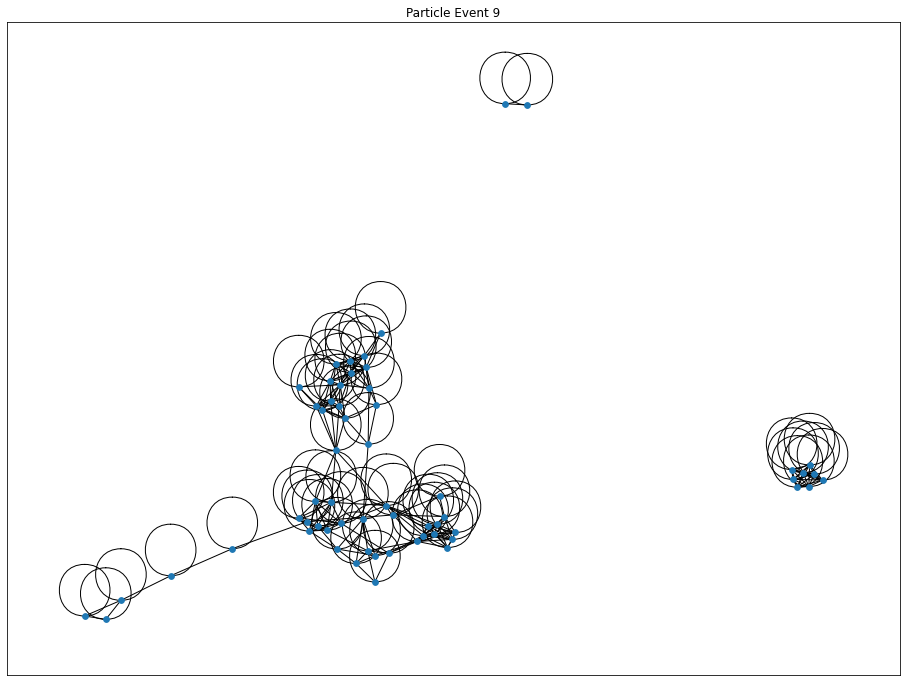

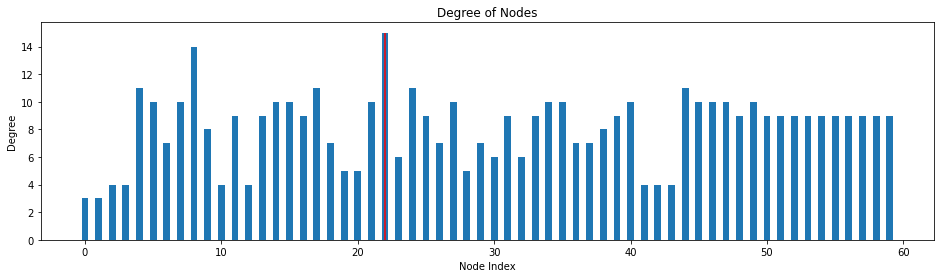

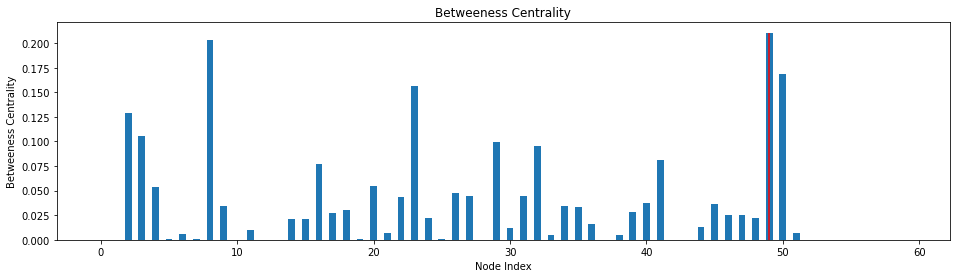

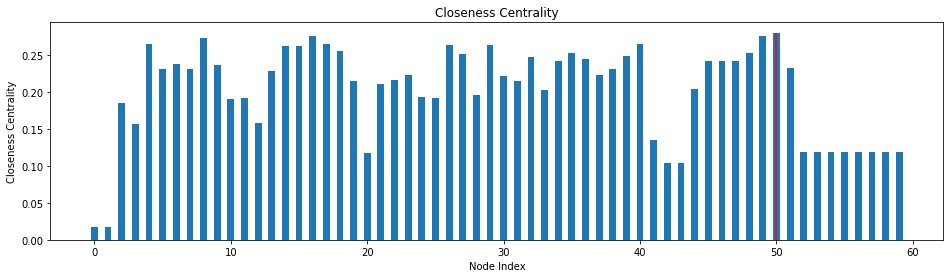

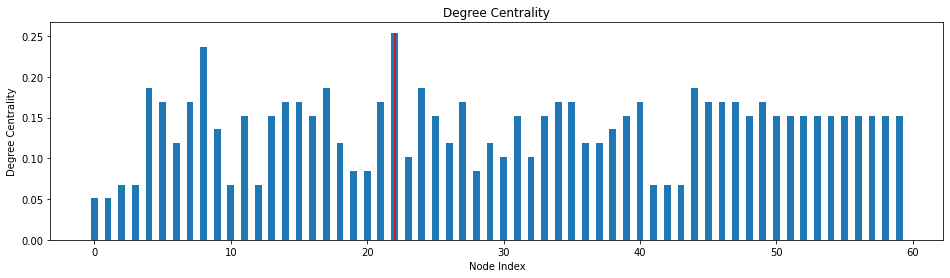

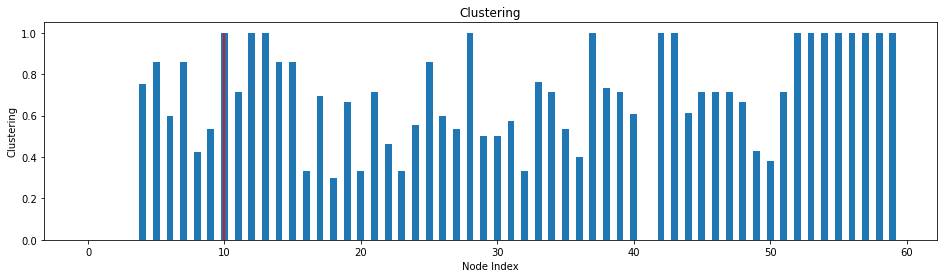

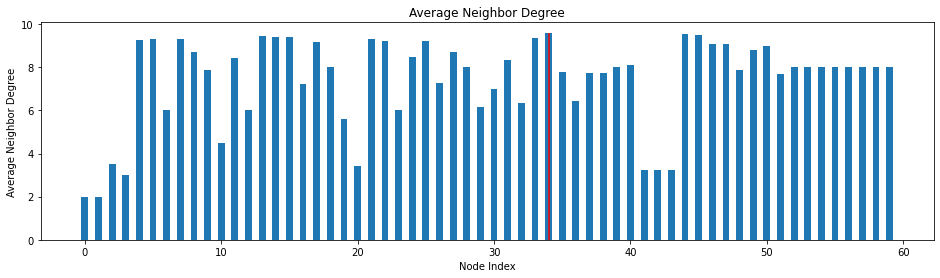

In [50]:
# Visualise the grpah 
data, G  = visualise_graph(data_knn_list_variable, event_id=9)

node_degrees, node_indices, max_degree, node_idx = calculate_node_degree(G)
plot_node_degree(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_betweeness_centrality(G)
plot_betweeness_centrality(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_closeness_centrality(G)
plot_closeness_centrality(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_degree_centrality(G)
plot_degree_centrality(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_clustering(G)
plot_clustering(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_average_neighbor_degree(G)
plot_average_neighbor_degree(node_degrees, node_indices, max_degree, node_idx )


# radius - node metrics

Node 3 has the largest degree value 58.
Node 3 has the largest value 0.1796804987336841.
Node 3 has the largest closeness centrality value 0.9491525423728814.
Node 3 has the largest degree centrality value 0.9830508474576272.
Node 6 has the largest clustering value 1.0.
Node 4 has the largest average neighbor degree value 58.0.


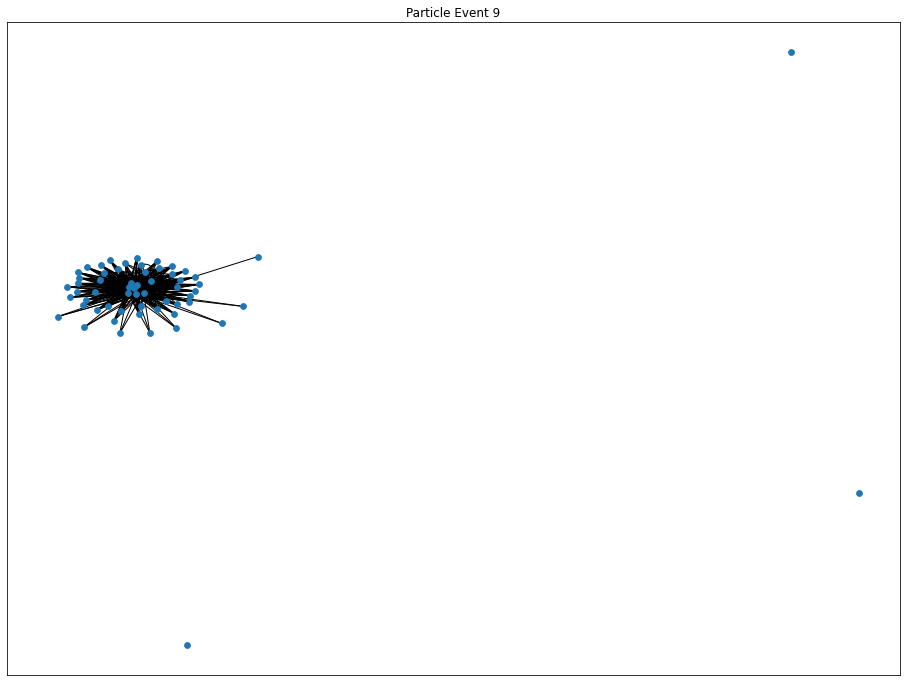

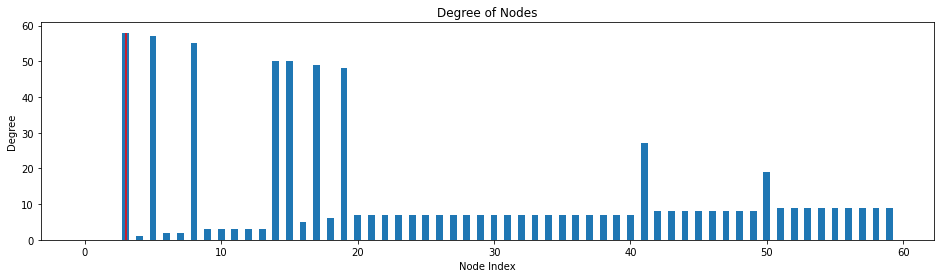

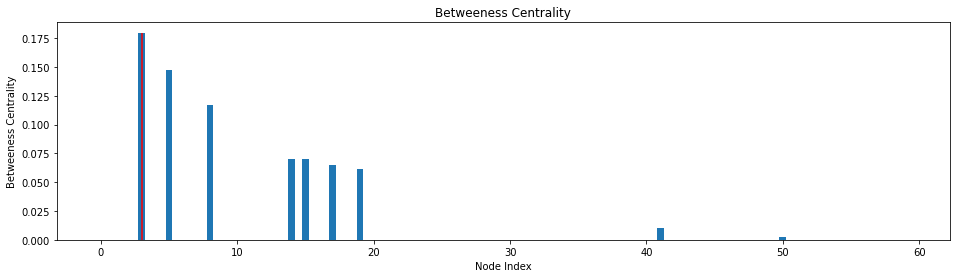

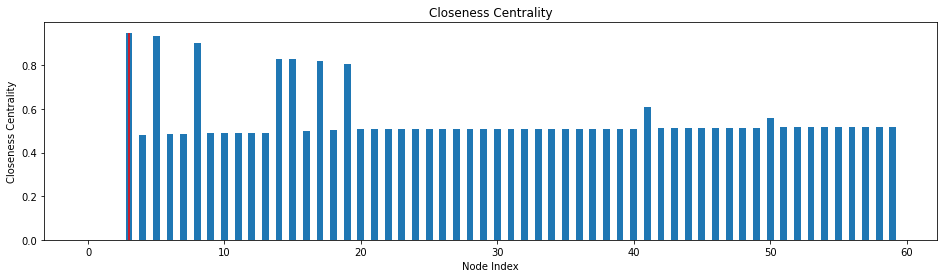

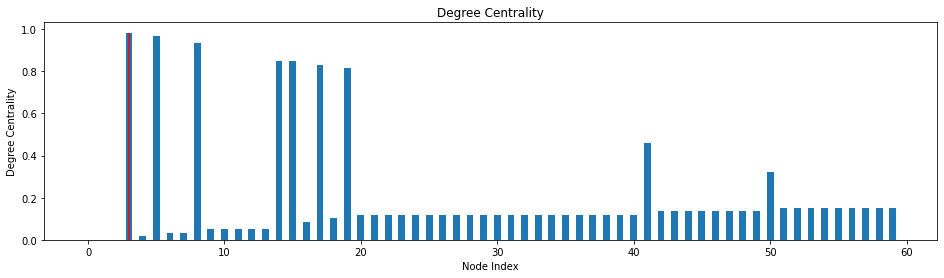

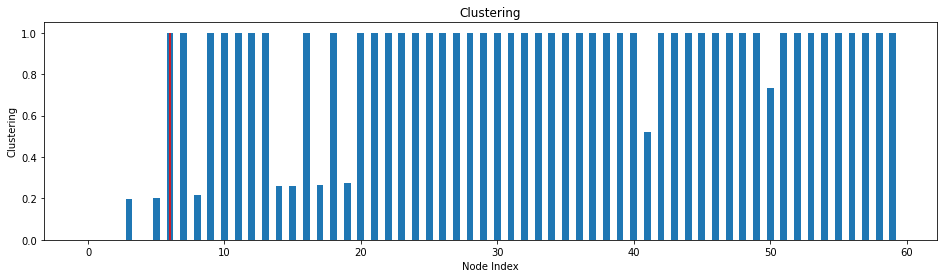

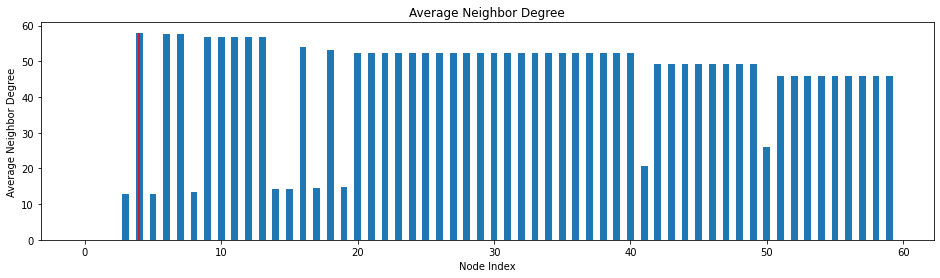

In [45]:
data, G  = visualise_graph(data_radius_list_variable, event_id=9)

node_degrees, node_indices, max_degree, node_idx = calculate_node_degree(G)
plot_node_degree(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_betweeness_centrality(G)
plot_betweeness_centrality(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_closeness_centrality(G)
plot_closeness_centrality(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_degree_centrality(G)
plot_degree_centrality(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_clustering(G)
plot_clustering(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_average_neighbor_degree(G)
plot_average_neighbor_degree(node_degrees, node_indices, max_degree, node_idx )


# label - node metrics

Node 0 has the largest degree value 61.
Node 0 has the largest value 1.0076785102480904e-05.
Node 0 has the largest closeness centrality value 1.0.
Node 0 has the largest degree centrality value 1.0338983050847457.
Node 58 has the largest clustering value 1.0.
Node 58 has the largest average neighbor degree value 61.0.


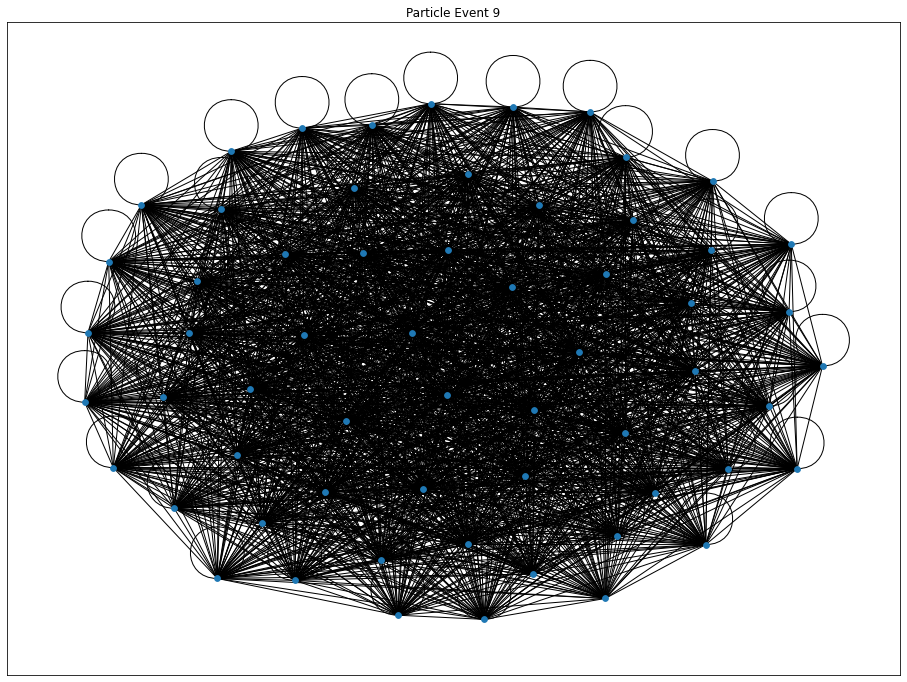

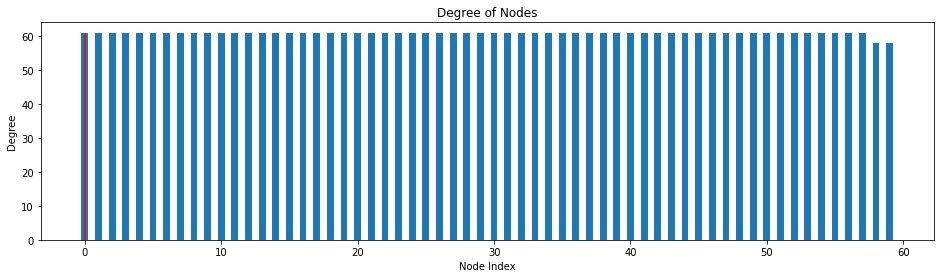

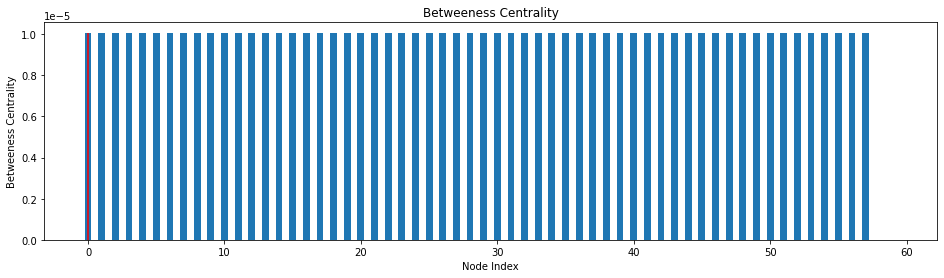

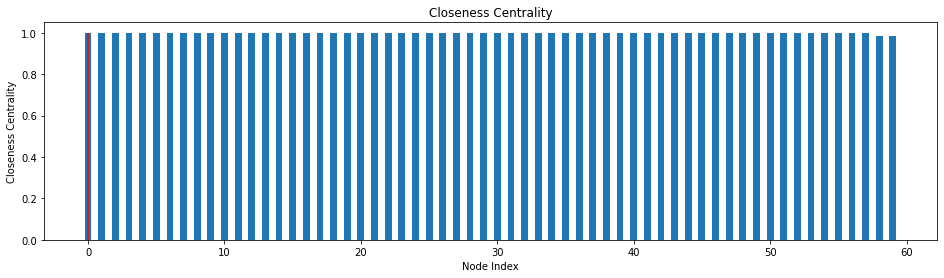

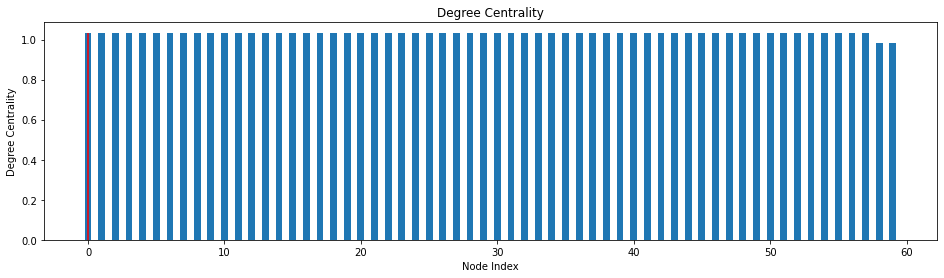

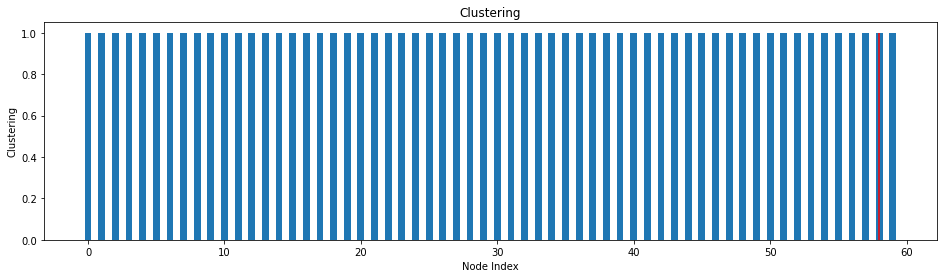

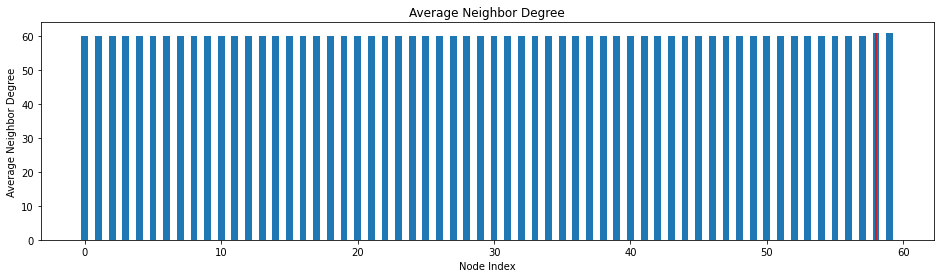

In [79]:
data, G  = visualise_graph(data_label_list_variable, event_id=9)

node_degrees, node_indices, max_degree, node_idx = calculate_node_degree(G)
plot_node_degree(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_betweeness_centrality(G)
plot_betweeness_centrality(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_closeness_centrality(G)
plot_closeness_centrality(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_degree_centrality(G)
plot_degree_centrality(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_clustering(G)
plot_clustering(node_degrees, node_indices, max_degree, node_idx )

node_degrees, node_indices, max_degree, node_idx = calculate_average_neighbor_degree(G)
plot_average_neighbor_degree(node_degrees, node_indices, max_degree, node_idx )

# Plot graph metrics against number of events 

#knn - graph metrics

Event 97 has the largest clustering value 0.810319926986594.
Event 81 has the largest global efficiency value 0.4366050260787099.
Event 97 has the largest local efficiency value 0.8624077739818478.
Event 71 has the largest transitivity value 0.8255813953488372.


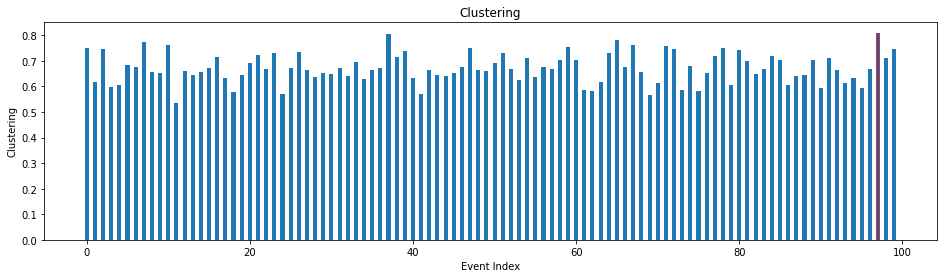

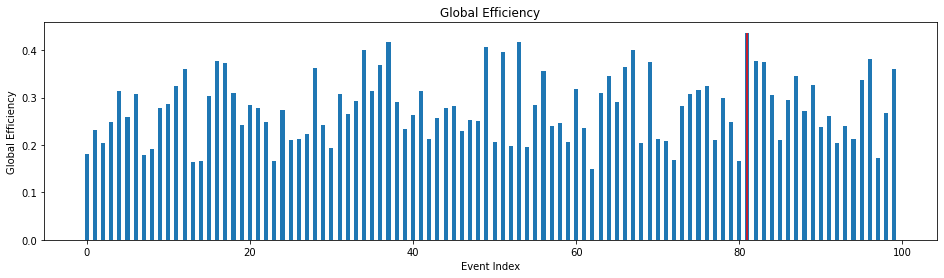

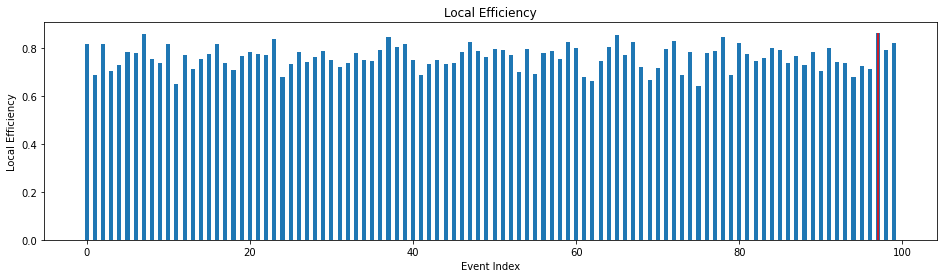

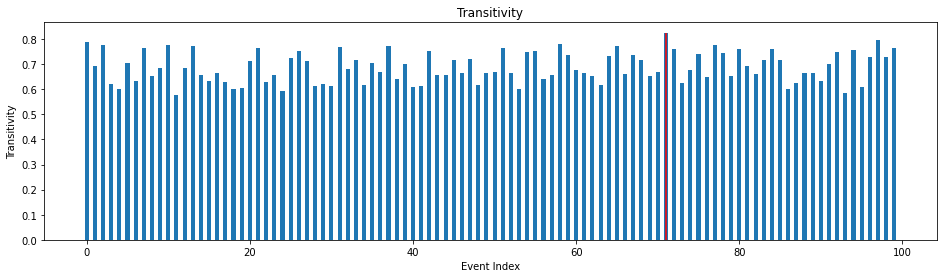

In [87]:
event_degrees, event_indices, max_degree, event_idx = calculate_average_clustering(graphs_nx_knn_variable)
plot_average_clustering(event_degrees, event_indices, max_degree, event_idx )

event_degrees, event_indices, max_degree, event_idx = calculate_global_efficiency(graphs_nx_knn_variable)
plot_global_efficiency(event_degrees, event_indices, max_degree, event_idx )

event_degrees, event_indices, max_degree, event_idx = calculate_local_efficiency(graphs_nx_knn_variable)
plot_local_efficiency(event_degrees, event_indices, max_degree, event_idx )

event_degrees, event_indices, max_degree, event_idx = calculate_transitivity(graphs_nx_knn_variable)
plot_transitivity(event_degrees, event_indices, max_degree, event_idx )

# radius - graph metrics

Event 2 has the largest clustering value 1.0.
Event 2 has the largest global efficiency value 1.0.
Event 2 has the largest local efficiency value 1.0.
Event 2 has the largest transitivity value 1.0.


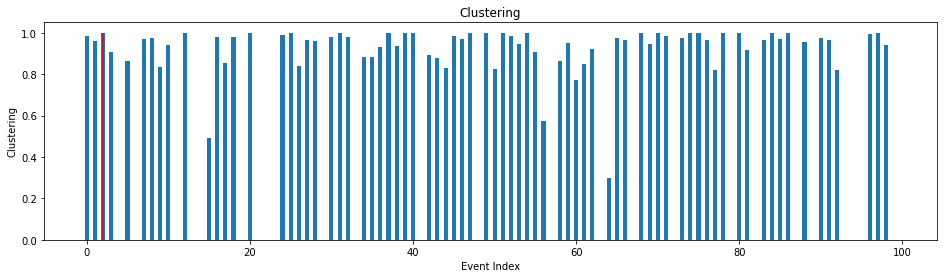

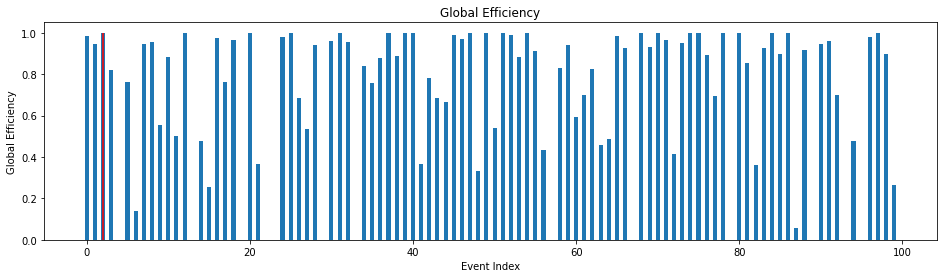

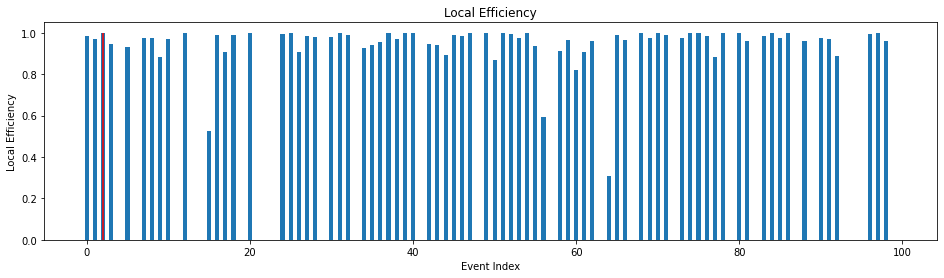

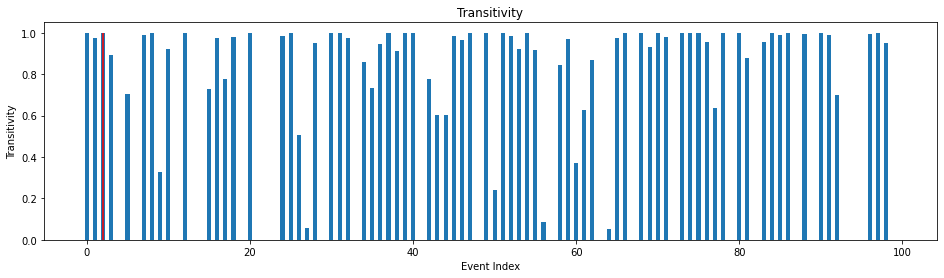

In [88]:
event_degrees, event_indices, max_degree, event_idx = calculate_average_clustering(graphs_nx_radius_variable)
plot_average_clustering(event_degrees, event_indices, max_degree, event_idx )

event_degrees, event_indices, max_degree, event_idx = calculate_global_efficiency(graphs_nx_radius_variable)
plot_global_efficiency(event_degrees, event_indices, max_degree, event_idx )

event_degrees, event_indices, max_degree, event_idx = calculate_local_efficiency(graphs_nx_radius_variable)
plot_local_efficiency(event_degrees, event_indices, max_degree, event_idx )

event_degrees, event_indices, max_degree, event_idx = calculate_transitivity(graphs_nx_radius_variable)
plot_transitivity(event_degrees, event_indices, max_degree, event_idx )

# label - graph metrics

Event 19 has the largest clustering value 0.9998058629392339.
Event 19 has the largest global efficiency value 0.9999029314696175.
Event 19 has the largest local efficiency value 0.9999029314696162.
Event 19 has the largest transitivity value 0.9998057875315596.


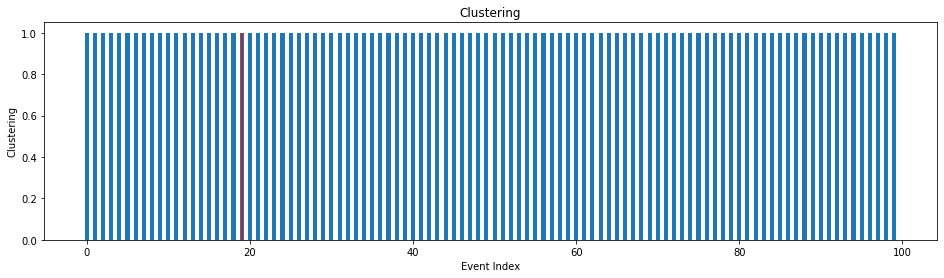

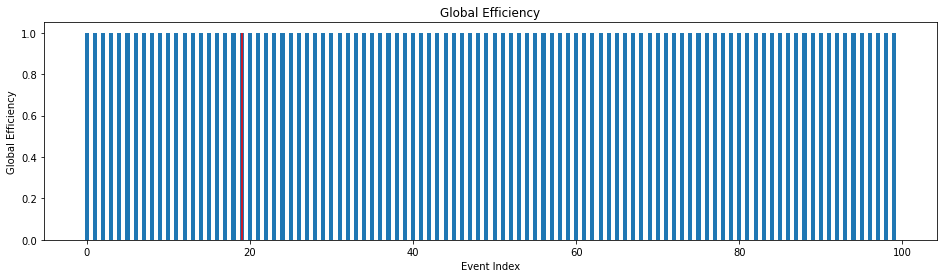

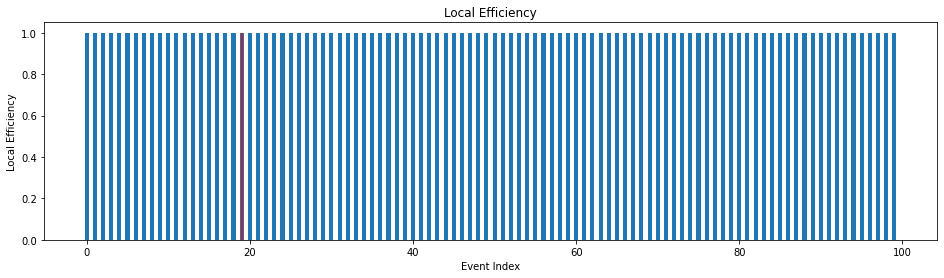

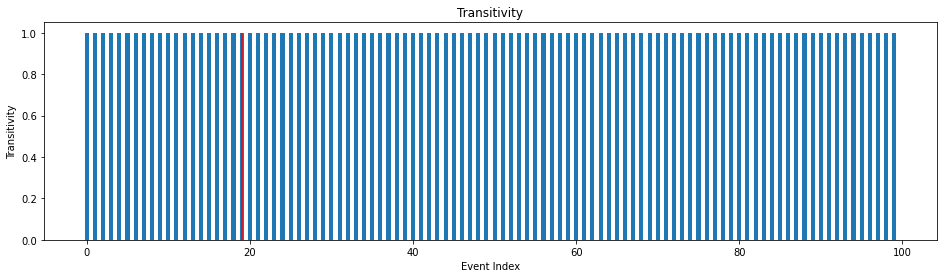

In [89]:
event_degrees, event_indices, max_degree, event_idx = calculate_average_clustering(graphs_nx_label_variable)
plot_average_clustering(event_degrees, event_indices, max_degree, event_idx )

event_degrees, event_indices, max_degree, event_idx = calculate_global_efficiency(graphs_nx_label_variable)
plot_global_efficiency(event_degrees, event_indices, max_degree, event_idx )

event_degrees, event_indices, max_degree, event_idx = calculate_local_efficiency(graphs_nx_label_variable)
plot_local_efficiency(event_degrees, event_indices, max_degree, event_idx )

event_degrees, event_indices, max_degree, event_idx = calculate_transitivity(graphs_nx_label_variable)
plot_transitivity(event_degrees, event_indices, max_degree, event_idx )